In [1]:
#makes sure to reload our modules on each execution

%load_ext autoreload 
%autoreload 1
%aimport gans, preprocessing, sourceSeparation

In [36]:
# generates preprocessed datasets for our models

batchSize = 64
noiseDim = 100

loader1, loader2, loader_mix_val, vallabel, loader_mix_test, testlabel = preprocessing.gen_loaders(
    noiseDim, 
    batchSize
)

Spike generator training


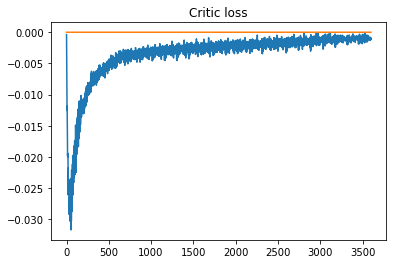

Critic loss -0.0009788628667593002

Epoch 24

Generated example:


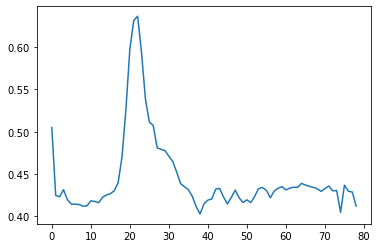

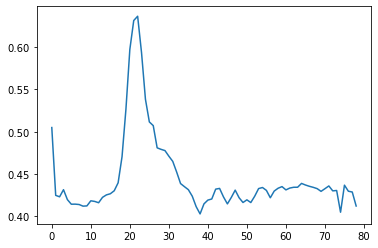

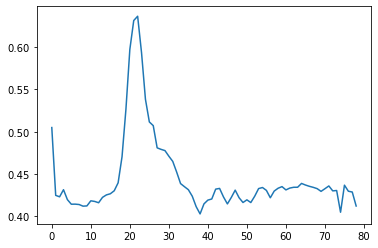

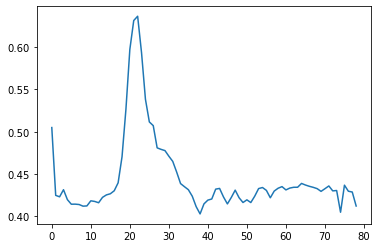

In [25]:
# declares and trains the gan for spikes 

gen1 = gans.Generator(inputSize=noiseDim, hiddenSize=79, outputSize=79)
critic1 = gans.Critic(inputSize=79, hiddenSize=50)

print("Spike generator training")

gans.adversarial_trainer( 
    train_loader = loader1,
    generator = gen1, 
    critic = critic1, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 25,
    printEpochs = 25
)

Background generator training


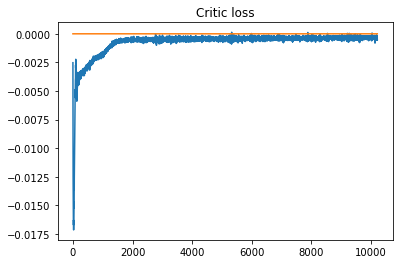

Critic loss -0.000542275607585907

Epoch 3

Generated example:


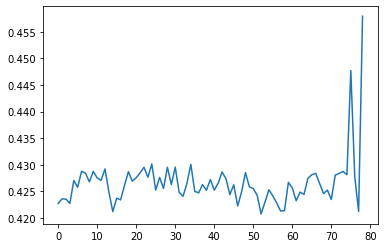

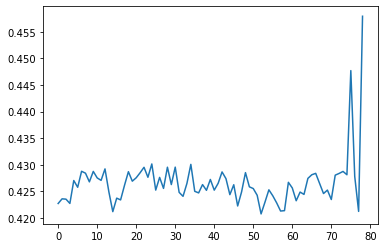

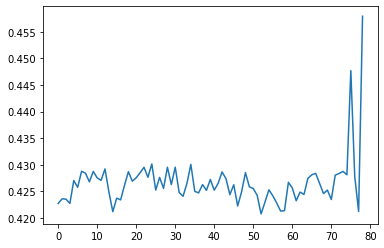

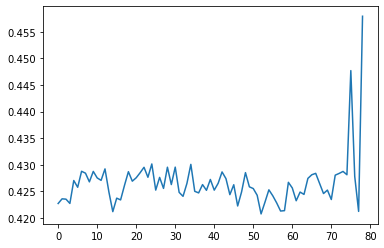

In [75]:
# declares and trains the gan for hash

gen2 = gans.Generator(inputSize=noiseDim, hiddenSize=25, outputSize=79)
critic2 = gans.Critic(inputSize=79, hiddenSize=50)
print("Background generator training")

gans.adversarial_trainer( 
    train_loader = loader2,
    generator = gen2, 
    critic = critic2, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 4,
    printEpochs = 4
)

Processing source  0
Processing source  1
Processing source  2
Processing source  3
Processing source  4
Processing source  5
Processing source  6
Processing source  7
Processing source  8
Processing source  9
Processing source  10
Processing source  11
Processing source  12
Processing source  13
Processing source  14
Processing source  15
Processing source  16
Processing source  17
Processing source  18
Processing source  19
Processing source  20
Processing source  21
Processing source  22
Processing source  23
Processing source  24
Processing source  25
Processing source  26
Processing source  27
Processing source  28
Processing source  29
Processing source  30
Processing source  31
Processing source  32
Processing source  33
Processing source  34
Processing source  35
Processing source  36
Processing source  37
Processing source  38
Processing source  39
Processing source  40
Processing source  41
Processing source  42
Processing source  43
Processing source  44
Processing source  4

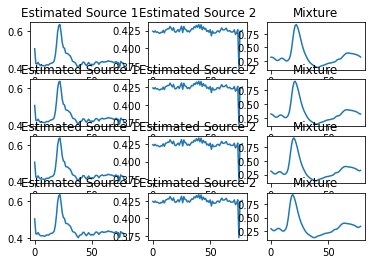

In [38]:
# separates the samples from loader_mix_val

cleanextractedSpikesValidation = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=loader_mix_val,
    epochs=100
)

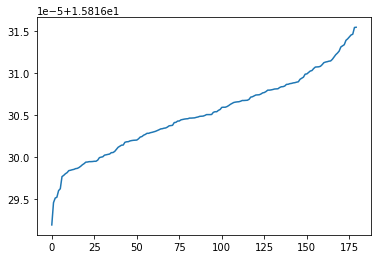

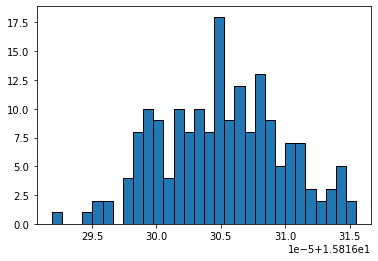

Precision: 0.08403361344537816
Recall: 0.5
Accuracy: 0.3388888888888889
F1: 0.14388489208633093


In [101]:
# some interpretation of results

import numpy as np
import torch
import matplotlib.pyplot as plt


extractedSpikesValidation = [ x for [[x]] in cleanextractedSpikesValidation]
extractedSpikesValidation = np.array(extractedSpikesValidation)
energy = []

for extractedSpike in extractedSpikesValidation:
    energy.append(sum(np.power(extractedSpike, 2)))

energy = np.array(energy)
hist, edges = np.histogram(energy, bins = 30)

plt.plot(np.sort(energy))
plt.show()
plt.bar(edges[:-1], hist, width=np.diff(edges), edgecolor="black", align="edge")
plt.show()

treshold =  30.3 * 1e-5 + 1.5816e1
    
res = []

for elem in energy:
    if elem > treshold:
        res.append(1)
    else:
        res.append(0)
    
truepos = 0
falsepos = 0
trueneg = 0
falseneg = 0

for i in range(0, len(vallabel)):
    if vallabel[i] == 1:
        if res[i] == 1:
            truepos += 1
        else:
            falseneg += 1
    else:
        if res[i] == 1:
            falsepos += 1
        else:
            trueneg += 1

precision = truepos / (truepos + falsepos)
recall = truepos / (truepos + falseneg)        
    
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("Accuracy: {}".format((truepos + trueneg) / len(vallabel)))
print("F1: {}".format(2 * ((precision * recall)/(precision+recall))))
